## 전처리한 데이터 가지고 오기

In [1]:
%pip install -q lightgbm scikit-learn optuna

Note: you may need to restart the kernel to use updated packages.


In [1]:
# ライブラリのインポート
import pandas as pd
import lightgbm as lgb
import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from lightgbm import early_stopping, log_evaluation

In [4]:
# データ読み込み
df = pd.read_csv('../data/combined_batches_cleaned_2.csv')

In [5]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103623 entries, 0 to 103622
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   url                   103623 non-null  object 
 1   url_type              103623 non-null  int64  
 2   url_len               103623 non-null  int64  
 3   letters_count         103623 non-null  int64  
 4   digits_count          103623 non-null  int64  
 5   special_chars_count   103623 non-null  int64  
 6   shortened             103623 non-null  int64  
 7   is_domain_in_url      103623 non-null  int64  
 8   secure_http           103623 non-null  int64  
 9   redirect_count        103623 non-null  int64  
 10  duration_sec          103623 non-null  float64
 11  meta_count            103623 non-null  float64
 12  link_count            103623 non-null  float64
 13  title_count           103623 non-null  float64
 14  has_title             103623 non-null  bool   
 15  

,url,url_type,url_len,letters_count,digits_count,special_chars_count,shortened,is_domain_in_url,secure_http,redirect_count,...,has_og_image,has_og_title,has_link_stylesheet,performance_score,FCP,LCP,CLS,TTFB,SpeedIndex,TBT
0,imdb.com/company/co0028450/,0,27,16,7,4,0,0,0,4,...,True,True,True,1.00,422.000000,422.000000,0.000000,203.0,588.375250,0.0
1,gamersunite.coolchaser.com/games/zoo-paradise/...,0,52,46,0,6,0,0,0,0,...,False,False,True,0.94,1028.000000,1048.000000,0.000000,547.0,1785.101583,0.0
2,https://medium.com/@djpizzo/i-guess-it-depends...,0,134,107,7,28,0,1,1,0,...,False,False,True,0.88,499.954928,499.954928,0.000269,451.0,688.260136,295.0
3,eslnotes.com/synopses.html,0,26,23,0,3,0,0,0,2,...,False,False,True,0.95,983.528140,983.528140,0.002545,187.0,1719.427284,0.0
4,123people.com/s/arashi,0,22,16,3,3,0,0,0,1,...,False,True,True,0.94,556.000000,685.000000,0.034427,955.0,2406.875644,0.0


特徴量とラベルに分割

In [6]:

df['digit_ratio'] = df['digits_count'] / (df['url_len'] + 1e-5)
df['meta_density'] = df['meta_count'] / (df['duration_sec'] + 1e-5)
df['performance_ratio'] = df['SpeedIndex'] / (df['duration_sec'] + 1e-5)
# 特徴量とラベルの分離
y = df['url_type']  # ← 例：0=benign, 1=phishing, 2=malwareなど
X = df.drop(columns=['url_type', 'url_len', 'letters_count','performance_score','title_count','is_domain_in_url'])
X = X.select_dtypes(include=['int64', 'float64', 'bool'])

学習・検証データに分割

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

LightGBMデータ形式に変換

In [8]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

### Optunaによるハイパーパラメータチューニング

In [9]:
from sklearn.metrics import f1_score
import lightgbm as lgb
import optuna
from lightgbm import early_stopping, log_evaluation

def objective(trial):
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'goss'])

    param = {
        'objective': 'multiclass',
        'num_class': y.nunique(),
        'metric': 'multi_logloss',
        'boosting_type': boosting_type,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 1.0),
        'max_bin': trial.suggest_int('max_bin', 128, 255),  # GPU互換範囲
        'verbosity': -1,
        'feature_pre_filter': False,
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0
    }

    # GOSS以外なら bagging を追加
    if boosting_type != 'goss':
        param.update({
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7)
        })

    num_boost_round = trial.suggest_int('num_boost_round', 100, 1000)

    train_dataset = lgb.Dataset(X_train, label=y_train)
    valid_dataset = lgb.Dataset(X_test, label=y_test)

    model = lgb.train(
        param,
        train_dataset,
        valid_sets=[valid_dataset],
        num_boost_round=num_boost_round,
        callbacks=[
            early_stopping(stopping_rounds=30),
            log_evaluation(period=50)
        ]
    )

    preds = model.predict(X_test)
    pred_labels = preds.argmax(axis=1)
    f1 = f1_score(y_test, pred_labels, average='macro')
    return f1


# Optunaの探索開始
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 最良パラメータの出力
print("🔧 Best parameters found by Optuna:")
print(study.best_params)


[I 2025-06-11 10:22:24,897] A new study created in memory with name: no-name-6de5b38f-4be7-4696-bb2a-41464a595780


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.399289
[100]	valid_0's multi_logloss: 0.387902


[I 2025-06-11 10:22:32,460] Trial 0 finished with value: 0.8372475172475543 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.16929832108032492, 'num_leaves': 136, 'max_depth': 12, 'min_data_in_leaf': 82, 'feature_fraction': 0.6136348821976824, 'lambda_l1': 3.434864488863779, 'lambda_l2': 4.545445377726794, 'min_gain_to_split': 0.9961964256292668, 'max_bin': 169, 'bagging_fraction': 0.7720328956465681, 'bagging_freq': 7, 'num_boost_round': 434}. Best is trial 0 with value: 0.8372475172475543.


[150]	valid_0's multi_logloss: 0.387443
Early stopping, best iteration is:
[124]	valid_0's multi_logloss: 0.387442
Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.455104
[100]	valid_0's multi_logloss: 0.408373
[150]	valid_0's multi_logloss: 0.386874


[I 2025-06-11 10:22:38,550] Trial 1 finished with value: 0.8381956445820172 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1986596036148668, 'num_leaves': 37, 'max_depth': 6, 'min_data_in_leaf': 56, 'feature_fraction': 0.6426096040231354, 'lambda_l1': 4.8596841064617955, 'lambda_l2': 4.404406104261808, 'min_gain_to_split': 0.40645683853592585, 'max_bin': 218, 'bagging_fraction': 0.7913473798837933, 'bagging_freq': 6, 'num_boost_round': 166}. Best is trial 1 with value: 0.8381956445820172.


Did not meet early stopping. Best iteration is:
[166]	valid_0's multi_logloss: 0.383548
Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.421944
[100]	valid_0's multi_logloss: 0.370218
[150]	valid_0's multi_logloss: 0.345234
[200]	valid_0's multi_logloss: 0.331244
[250]	valid_0's multi_logloss: 0.322853
[300]	valid_0's multi_logloss: 0.315639
[350]	valid_0's multi_logloss: 0.311011
[400]	valid_0's multi_logloss: 0.30886
[450]	valid_0's multi_logloss: 0.307854
[500]	valid_0's multi_logloss: 0.306915
Early stopping, best iteration is:
[518]	valid_0's multi_logloss: 0.306611


[I 2025-06-11 10:23:30,541] Trial 2 finished with value: 0.8662722473910976 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.10810712822435921, 'num_leaves': 107, 'max_depth': 10, 'min_data_in_leaf': 70, 'feature_fraction': 0.8314628986292951, 'lambda_l1': 0.05804011699317657, 'lambda_l2': 1.105332136896875, 'min_gain_to_split': 0.4068255424289675, 'max_bin': 204, 'num_boost_round': 933}. Best is trial 2 with value: 0.8662722473910976.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.369036
[100]	valid_0's multi_logloss: 0.334664
[150]	valid_0's multi_logloss: 0.324127
[200]	valid_0's multi_logloss: 0.320464
[250]	valid_0's multi_logloss: 0.319877
Early stopping, best iteration is:
[253]	valid_0's multi_logloss: 0.319524


[I 2025-06-11 10:23:58,021] Trial 3 finished with value: 0.8607876883199093 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.18389424195077603, 'num_leaves': 135, 'max_depth': 10, 'min_data_in_leaf': 27, 'feature_fraction': 0.7977846922770725, 'lambda_l1': 0.005287981007806031, 'lambda_l2': 1.6396994595206476, 'min_gain_to_split': 0.9468456459543543, 'max_bin': 203, 'num_boost_round': 988}. Best is trial 2 with value: 0.8662722473910976.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.562853
[100]	valid_0's multi_logloss: 0.48639
[150]	valid_0's multi_logloss: 0.453969
[200]	valid_0's multi_logloss: 0.432924
[250]	valid_0's multi_logloss: 0.41804
[300]	valid_0's multi_logloss: 0.406096
[350]	valid_0's multi_logloss: 0.398106
[400]	valid_0's multi_logloss: 0.392006
Did not meet early stopping. Best iteration is:
[441]	valid_0's multi_logloss: 0.388834


[I 2025-06-11 10:24:17,769] Trial 4 finished with value: 0.8372016195516762 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.04675681590547936, 'num_leaves': 30, 'max_depth': 13, 'min_data_in_leaf': 25, 'feature_fraction': 0.9411695625460088, 'lambda_l1': 3.8448220705803333, 'lambda_l2': 3.904052089120609, 'min_gain_to_split': 0.7100811011821346, 'max_bin': 135, 'bagging_fraction': 0.7913000423931345, 'bagging_freq': 3, 'num_boost_round': 441}. Best is trial 2 with value: 0.8662722473910976.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.449224
[100]	valid_0's multi_logloss: 0.398451
[150]	valid_0's multi_logloss: 0.372639
[200]	valid_0's multi_logloss: 0.355846
[250]	valid_0's multi_logloss: 0.343509
[300]	valid_0's multi_logloss: 0.335636
[350]	valid_0's multi_logloss: 0.329771
[400]	valid_0's multi_logloss: 0.325949
[450]	valid_0's multi_logloss: 0.32303
[500]	valid_0's multi_logloss: 0.320893
[550]	valid_0's multi_logloss: 0.319431
[600]	valid_0's multi_logloss: 0.318137
[650]	valid_0's multi_logloss: 0.31767
[700]	valid_0's multi_logloss: 0.316968
Did not meet early stopping. Best iteration is:
[711]	valid_0's multi_logloss: 0.316775


[I 2025-06-11 10:25:03,423] Trial 5 finished with value: 0.864418396822388 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.1253901846514577, 'num_leaves': 59, 'max_depth': 8, 'min_data_in_leaf': 67, 'feature_fraction': 0.6118698743384295, 'lambda_l1': 1.8800427595984899, 'lambda_l2': 1.6635488709535688, 'min_gain_to_split': 0.4755993278741485, 'max_bin': 145, 'num_boost_round': 711}. Best is trial 2 with value: 0.8662722473910976.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.560132
[100]	valid_0's multi_logloss: 0.508078
[150]	valid_0's multi_logloss: 0.477469
[200]	valid_0's multi_logloss: 0.457257
[250]	valid_0's multi_logloss: 0.441697
[300]	valid_0's multi_logloss: 0.428384
[350]	valid_0's multi_logloss: 0.419467
[400]	valid_0's multi_logloss: 0.41078
[450]	valid_0's multi_logloss: 0.40329
[500]	valid_0's multi_logloss: 0.396571
[550]	valid_0's multi_logloss: 0.390625
Did not meet early stopping. Best iteration is:
[569]	valid_0's multi_logloss: 0.388652


[I 2025-06-11 10:25:18,303] Trial 6 finished with value: 0.834665078698459 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.10234383649178942, 'num_leaves': 33, 'max_depth': 4, 'min_data_in_leaf': 29, 'feature_fraction': 0.7458748315809971, 'lambda_l1': 2.9089434265307506, 'lambda_l2': 2.6335492180702795, 'min_gain_to_split': 0.8491806890854748, 'max_bin': 194, 'num_boost_round': 569}. Best is trial 2 with value: 0.8662722473910976.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.518246
[100]	valid_0's multi_logloss: 0.466464
[150]	valid_0's multi_logloss: 0.437653
[200]	valid_0's multi_logloss: 0.417498
[250]	valid_0's multi_logloss: 0.403384
[300]	valid_0's multi_logloss: 0.391839
Did not meet early stopping. Best iteration is:
[311]	valid_0's multi_logloss: 0.390138


[I 2025-06-11 10:25:27,855] Trial 7 finished with value: 0.8346518535696603 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.12824755368045287, 'num_leaves': 21, 'max_depth': 5, 'min_data_in_leaf': 86, 'feature_fraction': 0.7392012566323282, 'lambda_l1': 3.9561589141755493, 'lambda_l2': 3.7729533246042477, 'min_gain_to_split': 0.9676270341225691, 'max_bin': 255, 'num_boost_round': 311}. Best is trial 2 with value: 0.8662722473910976.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.400591


[I 2025-06-11 10:25:31,153] Trial 8 finished with value: 0.8308002996615619 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.28883483932452114, 'num_leaves': 115, 'max_depth': 8, 'min_data_in_leaf': 80, 'feature_fraction': 0.8592739200617299, 'lambda_l1': 3.858359635952069, 'lambda_l2': 3.401779845274296, 'min_gain_to_split': 0.9808798159854716, 'max_bin': 132, 'bagging_fraction': 0.8644682287624028, 'bagging_freq': 6, 'num_boost_round': 635}. Best is trial 2 with value: 0.8662722473910976.


Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.39752
Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.544244
[100]	valid_0's multi_logloss: 0.501909


[I 2025-06-11 10:25:33,362] Trial 9 finished with value: 0.7935780203306981 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.22498072825821788, 'num_leaves': 63, 'max_depth': 3, 'min_data_in_leaf': 83, 'feature_fraction': 0.9827091105567894, 'lambda_l1': 4.819858861371045, 'lambda_l2': 3.1966355283847254, 'min_gain_to_split': 0.8222726002287155, 'max_bin': 205, 'bagging_fraction': 0.9423285680537783, 'bagging_freq': 1, 'num_boost_round': 131}. Best is trial 2 with value: 0.8662722473910976.


Did not meet early stopping. Best iteration is:
[131]	valid_0's multi_logloss: 0.484512
Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.546349
[100]	valid_0's multi_logloss: 0.44823
[150]	valid_0's multi_logloss: 0.405328
[200]	valid_0's multi_logloss: 0.380308
[250]	valid_0's multi_logloss: 0.362543
[300]	valid_0's multi_logloss: 0.350269
[350]	valid_0's multi_logloss: 0.340586
[400]	valid_0's multi_logloss: 0.332561
[450]	valid_0's multi_logloss: 0.32605
[500]	valid_0's multi_logloss: 0.320806
[550]	valid_0's multi_logloss: 0.316144
[600]	valid_0's multi_logloss: 0.312189
[650]	valid_0's multi_logloss: 0.308719
[700]	valid_0's multi_logloss: 0.305903
[750]	valid_0's multi_logloss: 0.303653
[800]	valid_0's multi_logloss: 0.301063
[850]	valid_0's multi_logloss: 0.299361
[900]	valid_0's multi_logloss: 0.297926
[950]	valid_0's multi_logloss: 0.296639
Did not meet early stopping. Best iteration is:
[982]	valid_0's multi_logloss: 0.295772


[I 2025-06-11 10:27:31,775] Trial 10 finished with value: 0.8709004840250789 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.03260753515329182, 'num_leaves': 97, 'max_depth': 15, 'min_data_in_leaf': 44, 'feature_fraction': 0.8767505961344296, 'lambda_l1': 0.01896557427575951, 'lambda_l2': 0.07568411602417391, 'min_gain_to_split': 0.0711348189679647, 'max_bin': 237, 'num_boost_round': 984}. Best is trial 10 with value: 0.8709004840250789.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.776568
[100]	valid_0's multi_logloss: 0.633063
[150]	valid_0's multi_logloss: 0.55681
[200]	valid_0's multi_logloss: 0.509893
[250]	valid_0's multi_logloss: 0.478121
[300]	valid_0's multi_logloss: 0.454363
[350]	valid_0's multi_logloss: 0.436028
[400]	valid_0's multi_logloss: 0.421781
[450]	valid_0's multi_logloss: 0.409619
[500]	valid_0's multi_logloss: 0.399294
[550]	valid_0's multi_logloss: 0.390698
[600]	valid_0's multi_logloss: 0.383174
[650]	valid_0's multi_logloss: 0.376724
[700]	valid_0's multi_logloss: 0.37083
[750]	valid_0's multi_logloss: 0.365676
[800]	valid_0's multi_logloss: 0.360823
[850]	valid_0's multi_logloss: 0.356161
[900]	valid_0's multi_logloss: 0.35224
[950]	valid_0's multi_logloss: 0.34866
Did not meet early stopping. Best iteration is:
[980]	valid_0's multi_logloss: 0.346588


[I 2025-06-11 10:29:36,242] Trial 11 finished with value: 0.8542554872686727 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.010211072644440433, 'num_leaves': 100, 'max_depth': 15, 'min_data_in_leaf': 46, 'feature_fraction': 0.8756996936923783, 'lambda_l1': 0.0386159916881432, 'lambda_l2': 0.5255208287093842, 'min_gain_to_split': 0.05461444317624292, 'max_bin': 239, 'num_boost_round': 980}. Best is trial 10 with value: 0.8709004840250789.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.444076
[100]	valid_0's multi_logloss: 0.382146
[150]	valid_0's multi_logloss: 0.353446
[200]	valid_0's multi_logloss: 0.336892
[250]	valid_0's multi_logloss: 0.325369
[300]	valid_0's multi_logloss: 0.317899
[350]	valid_0's multi_logloss: 0.311892
[400]	valid_0's multi_logloss: 0.308076
[450]	valid_0's multi_logloss: 0.30496
[500]	valid_0's multi_logloss: 0.302753
[550]	valid_0's multi_logloss: 0.300275
[600]	valid_0's multi_logloss: 0.299003
[650]	valid_0's multi_logloss: 0.297919
[700]	valid_0's multi_logloss: 0.29713
[750]	valid_0's multi_logloss: 0.296782
Early stopping, best iteration is:
[765]	valid_0's multi_logloss: 0.296542


[I 2025-06-11 10:31:02,755] Trial 12 finished with value: 0.8720077633456924 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.07302008880572022, 'num_leaves': 86, 'max_depth': 14, 'min_data_in_leaf': 46, 'feature_fraction': 0.8867270687728376, 'lambda_l1': 1.0516877500600468, 'lambda_l2': 0.09054656565688646, 'min_gain_to_split': 0.09442541829172423, 'max_bin': 229, 'num_boost_round': 819}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.476619
[100]	valid_0's multi_logloss: 0.402856
[150]	valid_0's multi_logloss: 0.371335
[200]	valid_0's multi_logloss: 0.351865
[250]	valid_0's multi_logloss: 0.338402
[300]	valid_0's multi_logloss: 0.32871
[350]	valid_0's multi_logloss: 0.320558
[400]	valid_0's multi_logloss: 0.315193
[450]	valid_0's multi_logloss: 0.310581
[500]	valid_0's multi_logloss: 0.307226
[550]	valid_0's multi_logloss: 0.304459
[600]	valid_0's multi_logloss: 0.302167
[650]	valid_0's multi_logloss: 0.300594
[700]	valid_0's multi_logloss: 0.298789
[750]	valid_0's multi_logloss: 0.297579
Did not meet early stopping. Best iteration is:
[791]	valid_0's multi_logloss: 0.29704


[I 2025-06-11 10:32:34,357] Trial 13 finished with value: 0.8709130662224686 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.05646825979111591, 'num_leaves': 81, 'max_depth': 15, 'min_data_in_leaf': 42, 'feature_fraction': 0.9125897340183917, 'lambda_l1': 1.137354289978669, 'lambda_l2': 0.017765971223994356, 'min_gain_to_split': 0.00936349343131318, 'max_bin': 234, 'num_boost_round': 793}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.460715
[100]	valid_0's multi_logloss: 0.393638
[150]	valid_0's multi_logloss: 0.363145
[200]	valid_0's multi_logloss: 0.345607
[250]	valid_0's multi_logloss: 0.333254
[300]	valid_0's multi_logloss: 0.324593
[350]	valid_0's multi_logloss: 0.317569
[400]	valid_0's multi_logloss: 0.312483
[450]	valid_0's multi_logloss: 0.308775
[500]	valid_0's multi_logloss: 0.305522
[550]	valid_0's multi_logloss: 0.303246
[600]	valid_0's multi_logloss: 0.301286
[650]	valid_0's multi_logloss: 0.299678
[700]	valid_0's multi_logloss: 0.29872
[750]	valid_0's multi_logloss: 0.298221
Did not meet early stopping. Best iteration is:
[797]	valid_0's multi_logloss: 0.297633


[I 2025-06-11 10:33:52,198] Trial 14 finished with value: 0.8703018963356152 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.0684378836009849, 'num_leaves': 73, 'max_depth': 13, 'min_data_in_leaf': 13, 'feature_fraction': 0.9311103611312957, 'lambda_l1': 1.3861325340023856, 'lambda_l2': 0.0846594401651664, 'min_gain_to_split': 0.20030458821761854, 'max_bin': 228, 'num_boost_round': 797}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.443237
[100]	valid_0's multi_logloss: 0.384704
[150]	valid_0's multi_logloss: 0.356336
[200]	valid_0's multi_logloss: 0.340112
[250]	valid_0's multi_logloss: 0.328493
[300]	valid_0's multi_logloss: 0.321047
[350]	valid_0's multi_logloss: 0.315078
[400]	valid_0's multi_logloss: 0.310489
[450]	valid_0's multi_logloss: 0.307586
[500]	valid_0's multi_logloss: 0.304881
[550]	valid_0's multi_logloss: 0.302786
[600]	valid_0's multi_logloss: 0.301286
[650]	valid_0's multi_logloss: 0.300626
[700]	valid_0's multi_logloss: 0.299957
[750]	valid_0's multi_logloss: 0.300112
Early stopping, best iteration is:
[722]	valid_0's multi_logloss: 0.299867


[I 2025-06-11 10:35:04,421] Trial 15 finished with value: 0.8697238680265144 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.07834305393824831, 'num_leaves': 78, 'max_depth': 12, 'min_data_in_leaf': 48, 'feature_fraction': 0.9331036473631555, 'lambda_l1': 1.101834306542911, 'lambda_l2': 0.8775329457586142, 'min_gain_to_split': 0.1896141577896116, 'max_bin': 254, 'num_boost_round': 804}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.476616
[100]	valid_0's multi_logloss: 0.413459
[150]	valid_0's multi_logloss: 0.383859
[200]	valid_0's multi_logloss: 0.365815
[250]	valid_0's multi_logloss: 0.352582
[300]	valid_0's multi_logloss: 0.34292
[350]	valid_0's multi_logloss: 0.335505
[400]	valid_0's multi_logloss: 0.329534
[450]	valid_0's multi_logloss: 0.324799
[500]	valid_0's multi_logloss: 0.321235
[550]	valid_0's multi_logloss: 0.31809
[600]	valid_0's multi_logloss: 0.315139
[650]	valid_0's multi_logloss: 0.313185
[700]	valid_0's multi_logloss: 0.311041
[750]	valid_0's multi_logloss: 0.309332
[800]	valid_0's multi_logloss: 0.308144
Did not meet early stopping. Best iteration is:
[821]	valid_0's multi_logloss: 0.307524


[I 2025-06-11 10:36:09,197] Trial 16 finished with value: 0.8684943927733474 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.07207087052791035, 'num_leaves': 52, 'max_depth': 15, 'min_data_in_leaf': 99, 'feature_fraction': 0.996198967629963, 'lambda_l1': 0.8325653054783577, 'lambda_l2': 1.8264153103600171, 'min_gain_to_split': 0.22069155595954504, 'max_bin': 176, 'num_boost_round': 821}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.662209
[100]	valid_0's multi_logloss: 0.534096
[150]	valid_0's multi_logloss: 0.4759
[200]	valid_0's multi_logloss: 0.441615
[250]	valid_0's multi_logloss: 0.418252
[300]	valid_0's multi_logloss: 0.401548
[350]	valid_0's multi_logloss: 0.388675
[400]	valid_0's multi_logloss: 0.377796
[450]	valid_0's multi_logloss: 0.369082
[500]	valid_0's multi_logloss: 0.361261
[550]	valid_0's multi_logloss: 0.354636
[600]	valid_0's multi_logloss: 0.348697
[650]	valid_0's multi_logloss: 0.343785
Did not meet early stopping. Best iteration is:
[663]	valid_0's multi_logloss: 0.342452


[I 2025-06-11 10:37:26,652] Trial 17 finished with value: 0.8540383837439783 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.018819830602366278, 'num_leaves': 92, 'max_depth': 13, 'min_data_in_leaf': 36, 'feature_fraction': 0.7698402272726761, 'lambda_l1': 2.016595458370132, 'lambda_l2': 0.8045741324271143, 'min_gain_to_split': 0.02141963631822419, 'max_bin': 222, 'num_boost_round': 663}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.493615
[100]	valid_0's multi_logloss: 0.411958
[150]	valid_0's multi_logloss: 0.378713
[200]	valid_0's multi_logloss: 0.357244
[250]	valid_0's multi_logloss: 0.343024
[300]	valid_0's multi_logloss: 0.332777
[350]	valid_0's multi_logloss: 0.325808
[400]	valid_0's multi_logloss: 0.320468
[450]	valid_0's multi_logloss: 0.31615
[500]	valid_0's multi_logloss: 0.31297
[550]	valid_0's multi_logloss: 0.31098
[600]	valid_0's multi_logloss: 0.309044
[650]	valid_0's multi_logloss: 0.308
[700]	valid_0's multi_logloss: 0.307191
[750]	valid_0's multi_logloss: 0.306796
[800]	valid_0's multi_logloss: 0.306541
[850]	valid_0's multi_logloss: 0.306364
Did not meet early stopping. Best iteration is:
[870]	valid_0's multi_logloss: 0.306284


[I 2025-06-11 10:39:24,869] Trial 18 finished with value: 0.8657721487178632 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.047455646606452476, 'num_leaves': 125, 'max_depth': 14, 'min_data_in_leaf': 58, 'feature_fraction': 0.6897504570600144, 'lambda_l1': 0.7426145978044625, 'lambda_l2': 2.3418556599475253, 'min_gain_to_split': 0.5963511240704085, 'max_bin': 242, 'num_boost_round': 870}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.395393
[100]	valid_0's multi_logloss: 0.349394
[150]	valid_0's multi_logloss: 0.327802
[200]	valid_0's multi_logloss: 0.315848
[250]	valid_0's multi_logloss: 0.308897
[300]	valid_0's multi_logloss: 0.306263
[350]	valid_0's multi_logloss: 0.305037
Early stopping, best iteration is:
[364]	valid_0's multi_logloss: 0.304849


[I 2025-06-11 10:40:07,053] Trial 19 finished with value: 0.8686419487271365 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.13041672703315704, 'num_leaves': 85, 'max_depth': 11, 'min_data_in_leaf': 11, 'feature_fraction': 0.8970955814270161, 'lambda_l1': 1.7756744364398471, 'lambda_l2': 0.48468337997975575, 'min_gain_to_split': 0.292554278940793, 'max_bin': 174, 'num_boost_round': 712}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.462761
[100]	valid_0's multi_logloss: 0.404753
[150]	valid_0's multi_logloss: 0.376598
[200]	valid_0's multi_logloss: 0.359846
[250]	valid_0's multi_logloss: 0.346802
[300]	valid_0's multi_logloss: 0.337565
[350]	valid_0's multi_logloss: 0.330415
[400]	valid_0's multi_logloss: 0.324687
[450]	valid_0's multi_logloss: 0.320021
[500]	valid_0's multi_logloss: 0.316136
Did not meet early stopping. Best iteration is:
[525]	valid_0's multi_logloss: 0.314791


[I 2025-06-11 10:40:45,535] Trial 20 finished with value: 0.8640481926670499 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.08885892668296196, 'num_leaves': 47, 'max_depth': 14, 'min_data_in_leaf': 36, 'feature_fraction': 0.8312382672900119, 'lambda_l1': 2.5495847065449007, 'lambda_l2': 1.3129650958021502, 'min_gain_to_split': 0.1425010034389038, 'max_bin': 218, 'num_boost_round': 525}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.507456
[100]	valid_0's multi_logloss: 0.421978
[150]	valid_0's multi_logloss: 0.383906
[200]	valid_0's multi_logloss: 0.362324
[250]	valid_0's multi_logloss: 0.347717
[300]	valid_0's multi_logloss: 0.336895
[350]	valid_0's multi_logloss: 0.328525
[400]	valid_0's multi_logloss: 0.321754
[450]	valid_0's multi_logloss: 0.316182
[500]	valid_0's multi_logloss: 0.311601
[550]	valid_0's multi_logloss: 0.308645
[600]	valid_0's multi_logloss: 0.305651
[650]	valid_0's multi_logloss: 0.303194
[700]	valid_0's multi_logloss: 0.301117
[750]	valid_0's multi_logloss: 0.299555
[800]	valid_0's multi_logloss: 0.298096
[850]	valid_0's multi_logloss: 0.296881
Did not meet early stopping. Best iteration is:
[886]	valid_0's multi_logloss: 0.296388


[I 2025-06-11 10:42:41,344] Trial 21 finished with value: 0.8718005205370055 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.04152607281402709, 'num_leaves': 97, 'max_depth': 15, 'min_data_in_leaf': 45, 'feature_fraction': 0.900541504520006, 'lambda_l1': 0.5649794016303861, 'lambda_l2': 0.0036578564670240454, 'min_gain_to_split': 0.08020929777109143, 'max_bin': 236, 'num_boost_round': 886}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.491525
[100]	valid_0's multi_logloss: 0.41578
[150]	valid_0's multi_logloss: 0.382867
[200]	valid_0's multi_logloss: 0.362869
[250]	valid_0's multi_logloss: 0.348042
[300]	valid_0's multi_logloss: 0.337464
[350]	valid_0's multi_logloss: 0.328954
[400]	valid_0's multi_logloss: 0.322971
[450]	valid_0's multi_logloss: 0.317914
[500]	valid_0's multi_logloss: 0.313519
[550]	valid_0's multi_logloss: 0.310078
[600]	valid_0's multi_logloss: 0.30694
[650]	valid_0's multi_logloss: 0.304711
[700]	valid_0's multi_logloss: 0.30269
[750]	valid_0's multi_logloss: 0.300969
[800]	valid_0's multi_logloss: 0.299571
[850]	valid_0's multi_logloss: 0.298354
Did not meet early stopping. Best iteration is:
[879]	valid_0's multi_logloss: 0.297737


[I 2025-06-11 10:44:09,167] Trial 22 finished with value: 0.871076976159912 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.053103255029529596, 'num_leaves': 70, 'max_depth': 14, 'min_data_in_leaf': 39, 'feature_fraction': 0.9130553369949178, 'lambda_l1': 0.6233100114797656, 'lambda_l2': 0.13065658765972987, 'min_gain_to_split': 0.30353147187346285, 'max_bin': 230, 'num_boost_round': 879}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.565215
[100]	valid_0's multi_logloss: 0.470286
[150]	valid_0's multi_logloss: 0.429241
[200]	valid_0's multi_logloss: 0.404168
[250]	valid_0's multi_logloss: 0.386828
[300]	valid_0's multi_logloss: 0.373861
[350]	valid_0's multi_logloss: 0.362836
[400]	valid_0's multi_logloss: 0.353822
[450]	valid_0's multi_logloss: 0.346637
[500]	valid_0's multi_logloss: 0.340729
[550]	valid_0's multi_logloss: 0.335872
[600]	valid_0's multi_logloss: 0.331268
[650]	valid_0's multi_logloss: 0.327376
[700]	valid_0's multi_logloss: 0.323763
[750]	valid_0's multi_logloss: 0.321021
[800]	valid_0's multi_logloss: 0.318486
[850]	valid_0's multi_logloss: 0.31593
[900]	valid_0's multi_logloss: 0.313677
Did not meet early stopping. Best iteration is:
[907]	valid_0's multi_logloss: 0.313407


[I 2025-06-11 10:45:33,089] Trial 23 finished with value: 0.8647785045614969 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.03238584287633539, 'num_leaves': 68, 'max_depth': 12, 'min_data_in_leaf': 62, 'feature_fraction': 0.9630441422720294, 'lambda_l1': 0.5804751981083889, 'lambda_l2': 0.43579064770975184, 'min_gain_to_split': 0.31753270387581883, 'max_bin': 248, 'num_boost_round': 907}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.406513
[100]	valid_0's multi_logloss: 0.35397
[150]	valid_0's multi_logloss: 0.329819
[200]	valid_0's multi_logloss: 0.316774
[250]	valid_0's multi_logloss: 0.309188
[300]	valid_0's multi_logloss: 0.304416
[350]	valid_0's multi_logloss: 0.301901
[400]	valid_0's multi_logloss: 0.300498
[450]	valid_0's multi_logloss: 0.299498
Early stopping, best iteration is:
[453]	valid_0's multi_logloss: 0.29944


[I 2025-06-11 10:46:43,819] Trial 24 finished with value: 0.8681327532925699 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.09439365880713976, 'num_leaves': 112, 'max_depth': 14, 'min_data_in_leaf': 52, 'feature_fraction': 0.8417372518124311, 'lambda_l1': 0.527647502955013, 'lambda_l2': 0.5610166961394906, 'min_gain_to_split': 0.10860765622357349, 'max_bin': 227, 'num_boost_round': 868}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.385305
[100]	valid_0's multi_logloss: 0.341171
[150]	valid_0's multi_logloss: 0.323341
[200]	valid_0's multi_logloss: 0.31506
[250]	valid_0's multi_logloss: 0.310934
[300]	valid_0's multi_logloss: 0.309075
[350]	valid_0's multi_logloss: 0.308278
Early stopping, best iteration is:
[350]	valid_0's multi_logloss: 0.308278


[I 2025-06-11 10:47:26,139] Trial 25 finished with value: 0.8636803238260707 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.15558211728065513, 'num_leaves': 94, 'max_depth': 11, 'min_data_in_leaf': 38, 'feature_fraction': 0.8972616885034902, 'lambda_l1': 1.4265007142189328, 'lambda_l2': 1.2887664263242486, 'min_gain_to_split': 0.30613949279978003, 'max_bin': 212, 'num_boost_round': 752}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.530184
[100]	valid_0's multi_logloss: 0.439009
[150]	valid_0's multi_logloss: 0.398885
[200]	valid_0's multi_logloss: 0.375688
[250]	valid_0's multi_logloss: 0.359686
[300]	valid_0's multi_logloss: 0.347697
[350]	valid_0's multi_logloss: 0.338238
[400]	valid_0's multi_logloss: 0.330291
[450]	valid_0's multi_logloss: 0.323796
[500]	valid_0's multi_logloss: 0.318918
[550]	valid_0's multi_logloss: 0.314619
[600]	valid_0's multi_logloss: 0.310847
[650]	valid_0's multi_logloss: 0.307863
[700]	valid_0's multi_logloss: 0.305145
[750]	valid_0's multi_logloss: 0.302618
[800]	valid_0's multi_logloss: 0.300805
[850]	valid_0's multi_logloss: 0.298988
[900]	valid_0's multi_logloss: 0.297761
Did not meet early stopping. Best iteration is:
[901]	valid_0's multi_logloss: 0.297739


[I 2025-06-11 10:49:09,784] Trial 26 finished with value: 0.8693887092453444 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.03664777212543638, 'num_leaves': 87, 'max_depth': 14, 'min_data_in_leaf': 21, 'feature_fraction': 0.9605902665305991, 'lambda_l1': 0.4831674038906609, 'lambda_l2': 0.3063349161487427, 'min_gain_to_split': 0.24544397905618798, 'max_bin': 189, 'num_boost_round': 901}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.449804
[100]	valid_0's multi_logloss: 0.37945
[150]	valid_0's multi_logloss: 0.350357
[200]	valid_0's multi_logloss: 0.334518
[250]	valid_0's multi_logloss: 0.324184
[300]	valid_0's multi_logloss: 0.31805
[350]	valid_0's multi_logloss: 0.314102
[400]	valid_0's multi_logloss: 0.311394
[450]	valid_0's multi_logloss: 0.309736
[500]	valid_0's multi_logloss: 0.308509
[550]	valid_0's multi_logloss: 0.307845
[600]	valid_0's multi_logloss: 0.307492
Did not meet early stopping. Best iteration is:
[611]	valid_0's multi_logloss: 0.307446


[I 2025-06-11 10:50:49,520] Trial 27 finished with value: 0.8650215791460817 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.06047517155045713, 'num_leaves': 148, 'max_depth': 13, 'min_data_in_leaf': 33, 'feature_fraction': 0.7966977640116981, 'lambda_l1': 2.253142691683222, 'lambda_l2': 2.1109461004952674, 'min_gain_to_split': 0.15710369389006346, 'max_bin': 245, 'bagging_fraction': 0.6011391446217309, 'bagging_freq': 3, 'num_boost_round': 611}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.397851
[100]	valid_0's multi_logloss: 0.356548
[150]	valid_0's multi_logloss: 0.340013
[200]	valid_0's multi_logloss: 0.332482
[250]	valid_0's multi_logloss: 0.328116
[300]	valid_0's multi_logloss: 0.326503
[350]	valid_0's multi_logloss: 0.325394
Early stopping, best iteration is:
[353]	valid_0's multi_logloss: 0.325304


[I 2025-06-11 10:51:16,103] Trial 28 finished with value: 0.8600231035236764 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.24834980654141559, 'num_leaves': 73, 'max_depth': 7, 'min_data_in_leaf': 19, 'feature_fraction': 0.9064125966911682, 'lambda_l1': 1.5021878850949668, 'lambda_l2': 0.9611407001326184, 'min_gain_to_split': 0.3586846605869514, 'max_bin': 230, 'num_boost_round': 728}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.37821
[100]	valid_0's multi_logloss: 0.341341
[150]	valid_0's multi_logloss: 0.33114
[200]	valid_0's multi_logloss: 0.328142
[250]	valid_0's multi_logloss: 0.326808
[300]	valid_0's multi_logloss: 0.32512
[350]	valid_0's multi_logloss: 0.324777
[400]	valid_0's multi_logloss: 0.324075
[450]	valid_0's multi_logloss: 0.323633
[500]	valid_0's multi_logloss: 0.323223
Did not meet early stopping. Best iteration is:
[479]	valid_0's multi_logloss: 0.323107


[I 2025-06-11 10:51:41,064] Trial 29 finished with value: 0.8589882739059842 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.14708050708575898, 'num_leaves': 105, 'max_depth': 12, 'min_data_in_leaf': 49, 'feature_fraction': 0.8639844514582301, 'lambda_l1': 1.0263743044101874, 'lambda_l2': 0.7409085056617825, 'min_gain_to_split': 0.5630673991763357, 'max_bin': 189, 'bagging_fraction': 0.6034402700689488, 'bagging_freq': 1, 'num_boost_round': 501}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.407802
[100]	valid_0's multi_logloss: 0.356536
[150]	valid_0's multi_logloss: 0.333506
[200]	valid_0's multi_logloss: 0.32058
[250]	valid_0's multi_logloss: 0.313035
[300]	valid_0's multi_logloss: 0.308795
Did not meet early stopping. Best iteration is:
[321]	valid_0's multi_logloss: 0.30728


[I 2025-06-11 10:52:27,411] Trial 30 finished with value: 0.866963577534313 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.10990806931949595, 'num_leaves': 124, 'max_depth': 11, 'min_data_in_leaf': 42, 'feature_fraction': 0.8202609012654017, 'lambda_l1': 2.773449132607159, 'lambda_l2': 4.802138914663335, 'min_gain_to_split': 0.09158765291821203, 'max_bin': 152, 'num_boost_round': 321}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.471699
[100]	valid_0's multi_logloss: 0.398795
[150]	valid_0's multi_logloss: 0.366926
[200]	valid_0's multi_logloss: 0.348157
[250]	valid_0's multi_logloss: 0.335325
[300]	valid_0's multi_logloss: 0.325721
[350]	valid_0's multi_logloss: 0.318824
[400]	valid_0's multi_logloss: 0.313284
[450]	valid_0's multi_logloss: 0.308821
[500]	valid_0's multi_logloss: 0.305326
[550]	valid_0's multi_logloss: 0.302776
[600]	valid_0's multi_logloss: 0.300753
[650]	valid_0's multi_logloss: 0.298951
[700]	valid_0's multi_logloss: 0.297829
[750]	valid_0's multi_logloss: 0.29676
[800]	valid_0's multi_logloss: 0.295773
Did not meet early stopping. Best iteration is:
[836]	valid_0's multi_logloss: 0.295397


[I 2025-06-11 10:54:02,572] Trial 31 finished with value: 0.8706558984864596 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.05820176371949702, 'num_leaves': 83, 'max_depth': 15, 'min_data_in_leaf': 41, 'feature_fraction': 0.9135101925202659, 'lambda_l1': 1.2468983989306284, 'lambda_l2': 0.004582341462335271, 'min_gain_to_split': 0.013263198141209269, 'max_bin': 232, 'num_boost_round': 837}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.635645
[100]	valid_0's multi_logloss: 0.517375
[150]	valid_0's multi_logloss: 0.463298
[200]	valid_0's multi_logloss: 0.431299
[250]	valid_0's multi_logloss: 0.409641
[300]	valid_0's multi_logloss: 0.393671
[350]	valid_0's multi_logloss: 0.381143
[400]	valid_0's multi_logloss: 0.370868
[450]	valid_0's multi_logloss: 0.362582
[500]	valid_0's multi_logloss: 0.355148
[550]	valid_0's multi_logloss: 0.349112
[600]	valid_0's multi_logloss: 0.343914
[650]	valid_0's multi_logloss: 0.338983
[700]	valid_0's multi_logloss: 0.334775
[750]	valid_0's multi_logloss: 0.331112
Did not meet early stopping. Best iteration is:
[762]	valid_0's multi_logloss: 0.330287


[I 2025-06-11 10:55:29,012] Trial 32 finished with value: 0.8589271016652891 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.020786769995641746, 'num_leaves': 80, 'max_depth': 15, 'min_data_in_leaf': 56, 'feature_fraction': 0.9643149766696515, 'lambda_l1': 0.4305031553283735, 'lambda_l2': 0.24862543457089145, 'min_gain_to_split': 0.0014989508425204516, 'max_bin': 213, 'num_boost_round': 762}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.463459
[100]	valid_0's multi_logloss: 0.40133
[150]	valid_0's multi_logloss: 0.37206
[200]	valid_0's multi_logloss: 0.354832
[250]	valid_0's multi_logloss: 0.342051
[300]	valid_0's multi_logloss: 0.332376
[350]	valid_0's multi_logloss: 0.325188
[400]	valid_0's multi_logloss: 0.319134
[450]	valid_0's multi_logloss: 0.314692
[500]	valid_0's multi_logloss: 0.310779
[550]	valid_0's multi_logloss: 0.308299
[600]	valid_0's multi_logloss: 0.305439
[650]	valid_0's multi_logloss: 0.303497
[700]	valid_0's multi_logloss: 0.302104
[750]	valid_0's multi_logloss: 0.301448
[800]	valid_0's multi_logloss: 0.300563
[850]	valid_0's multi_logloss: 0.29963
[900]	valid_0's multi_logloss: 0.29899
Did not meet early stopping. Best iteration is:
[914]	valid_0's multi_logloss: 0.29871


[I 2025-06-11 10:56:39,566] Trial 33 finished with value: 0.8709374894026669 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.0793852293520011, 'num_leaves': 53, 'max_depth': 14, 'min_data_in_leaf': 31, 'feature_fraction': 0.9161804487541535, 'lambda_l1': 0.8910415437628064, 'lambda_l2': 1.2063353128457552, 'min_gain_to_split': 0.1288252614527972, 'max_bin': 238, 'num_boost_round': 914}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.471388
[100]	valid_0's multi_logloss: 0.412102
[150]	valid_0's multi_logloss: 0.383832
[200]	valid_0's multi_logloss: 0.364499
[250]	valid_0's multi_logloss: 0.351329
[300]	valid_0's multi_logloss: 0.341069
[350]	valid_0's multi_logloss: 0.332997
[400]	valid_0's multi_logloss: 0.326973
[450]	valid_0's multi_logloss: 0.321825
[500]	valid_0's multi_logloss: 0.317345
[550]	valid_0's multi_logloss: 0.314288
[600]	valid_0's multi_logloss: 0.31172
[650]	valid_0's multi_logloss: 0.30948
[700]	valid_0's multi_logloss: 0.307084
[750]	valid_0's multi_logloss: 0.304993
[800]	valid_0's multi_logloss: 0.303312
[850]	valid_0's multi_logloss: 0.302488
[900]	valid_0's multi_logloss: 0.301481
Did not meet early stopping. Best iteration is:
[926]	valid_0's multi_logloss: 0.300893


[I 2025-06-11 10:57:41,989] Trial 34 finished with value: 0.8692352353544934 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.08173342090953292, 'num_leaves': 43, 'max_depth': 14, 'min_data_in_leaf': 29, 'feature_fraction': 0.9405146793112943, 'lambda_l1': 0.33589598268060894, 'lambda_l2': 1.2768323674157391, 'min_gain_to_split': 0.12383808326036068, 'max_bin': 223, 'num_boost_round': 929}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.425474
[100]	valid_0's multi_logloss: 0.372326
[150]	valid_0's multi_logloss: 0.346422
[200]	valid_0's multi_logloss: 0.331925
[250]	valid_0's multi_logloss: 0.322674
[300]	valid_0's multi_logloss: 0.316607
[350]	valid_0's multi_logloss: 0.31203
[400]	valid_0's multi_logloss: 0.309405
[450]	valid_0's multi_logloss: 0.307942
[500]	valid_0's multi_logloss: 0.306477
[550]	valid_0's multi_logloss: 0.306432
Early stopping, best iteration is:
[523]	valid_0's multi_logloss: 0.306107


[I 2025-06-11 10:58:23,221] Trial 35 finished with value: 0.8677424425969994 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.11161552425497606, 'num_leaves': 59, 'max_depth': 13, 'min_data_in_leaf': 32, 'feature_fraction': 0.8861496246857427, 'lambda_l1': 0.8329812964837415, 'lambda_l2': 1.1127984899687873, 'min_gain_to_split': 0.2563674353246713, 'max_bin': 248, 'bagging_fraction': 0.6935119678014935, 'bagging_freq': 4, 'num_boost_round': 944}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.402399
[100]	valid_0's multi_logloss: 0.358886
[150]	valid_0's multi_logloss: 0.336571
[200]	valid_0's multi_logloss: 0.326156
[250]	valid_0's multi_logloss: 0.321204
[300]	valid_0's multi_logloss: 0.31725
[350]	valid_0's multi_logloss: 0.31529
Early stopping, best iteration is:
[369]	valid_0's multi_logloss: 0.315121


[I 2025-06-11 10:58:54,007] Trial 36 finished with value: 0.8630225121172935 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.18689576133106348, 'num_leaves': 53, 'max_depth': 10, 'min_data_in_leaf': 22, 'feature_fraction': 0.8478093759361256, 'lambda_l1': 0.3161044235058082, 'lambda_l2': 0.6560715307153981, 'min_gain_to_split': 0.40786404786109254, 'max_bin': 217, 'num_boost_round': 853}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.534014
[100]	valid_0's multi_logloss: 0.4502
[150]	valid_0's multi_logloss: 0.412575
[200]	valid_0's multi_logloss: 0.390164
[250]	valid_0's multi_logloss: 0.373952
[300]	valid_0's multi_logloss: 0.361736
[350]	valid_0's multi_logloss: 0.352336
[400]	valid_0's multi_logloss: 0.344572
[450]	valid_0's multi_logloss: 0.338063
[500]	valid_0's multi_logloss: 0.332904
[550]	valid_0's multi_logloss: 0.32823
[600]	valid_0's multi_logloss: 0.324358
[650]	valid_0's multi_logloss: 0.321009
[700]	valid_0's multi_logloss: 0.318053
[750]	valid_0's multi_logloss: 0.315323
[800]	valid_0's multi_logloss: 0.312985
[850]	valid_0's multi_logloss: 0.310971
[900]	valid_0's multi_logloss: 0.309038
[950]	valid_0's multi_logloss: 0.307779
Did not meet early stopping. Best iteration is:
[997]	valid_0's multi_logloss: 0.306434


[I 2025-06-11 11:00:27,773] Trial 37 finished with value: 0.8679644299261856 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.04115258178645113, 'num_leaves': 65, 'max_depth': 12, 'min_data_in_leaf': 63, 'feature_fraction': 0.9253772529575128, 'lambda_l1': 1.6508499104476386, 'lambda_l2': 1.6864023253208384, 'min_gain_to_split': 0.1750476125713144, 'max_bin': 198, 'num_boost_round': 997}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.474978
[100]	valid_0's multi_logloss: 0.41863
[150]	valid_0's multi_logloss: 0.390113
[200]	valid_0's multi_logloss: 0.372117
[250]	valid_0's multi_logloss: 0.359429
[300]	valid_0's multi_logloss: 0.348557
[350]	valid_0's multi_logloss: 0.341029
[400]	valid_0's multi_logloss: 0.33553
[450]	valid_0's multi_logloss: 0.330754
[500]	valid_0's multi_logloss: 0.326973
[550]	valid_0's multi_logloss: 0.323555
[600]	valid_0's multi_logloss: 0.320595
[650]	valid_0's multi_logloss: 0.317639
Did not meet early stopping. Best iteration is:
[669]	valid_0's multi_logloss: 0.316993


[I 2025-06-11 11:01:07,888] Trial 38 finished with value: 0.8608997010937061 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.0909259415509277, 'num_leaves': 40, 'max_depth': 9, 'min_data_in_leaf': 54, 'feature_fraction': 0.8188650461511745, 'lambda_l1': 0.8899941941525441, 'lambda_l2': 0.3051966202173141, 'min_gain_to_split': 0.44523780444875893, 'max_bin': 210, 'num_boost_round': 669}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.500898
[100]	valid_0's multi_logloss: 0.419317
[150]	valid_0's multi_logloss: 0.386522
[200]	valid_0's multi_logloss: 0.367341
[250]	valid_0's multi_logloss: 0.352984
[300]	valid_0's multi_logloss: 0.342231
[350]	valid_0's multi_logloss: 0.333703
[400]	valid_0's multi_logloss: 0.327013
[450]	valid_0's multi_logloss: 0.321741
[500]	valid_0's multi_logloss: 0.31689
[550]	valid_0's multi_logloss: 0.313011
[600]	valid_0's multi_logloss: 0.309444
[650]	valid_0's multi_logloss: 0.306823
[700]	valid_0's multi_logloss: 0.303963
[750]	valid_0's multi_logloss: 0.301292
[800]	valid_0's multi_logloss: 0.299173
[850]	valid_0's multi_logloss: 0.296993
[900]	valid_0's multi_logloss: 0.295789
Did not meet early stopping. Best iteration is:
[939]	valid_0's multi_logloss: 0.29486


[I 2025-06-11 11:02:33,156] Trial 39 finished with value: 0.8717217189012697 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.05271922827839084, 'num_leaves': 73, 'max_depth': 14, 'min_data_in_leaf': 16, 'feature_fraction': 0.6570164882412244, 'lambda_l1': 0.2527198934687137, 'lambda_l2': 1.473029236017045, 'min_gain_to_split': 0.07998486616446898, 'max_bin': 238, 'bagging_fraction': 0.988430672041409, 'bagging_freq': 5, 'num_boost_round': 939}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.498555
[100]	valid_0's multi_logloss: 0.420241
[150]	valid_0's multi_logloss: 0.387567
[200]	valid_0's multi_logloss: 0.368641
[250]	valid_0's multi_logloss: 0.35542
[300]	valid_0's multi_logloss: 0.346671
[350]	valid_0's multi_logloss: 0.342697
[400]	valid_0's multi_logloss: 0.340291
[450]	valid_0's multi_logloss: 0.339148
[500]	valid_0's multi_logloss: 0.338613
[550]	valid_0's multi_logloss: 0.338484
[600]	valid_0's multi_logloss: 0.338022
Early stopping, best iteration is:
[600]	valid_0's multi_logloss: 0.338022


[I 2025-06-11 11:03:08,963] Trial 40 finished with value: 0.8546929613447839 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.0533709984881295, 'num_leaves': 74, 'max_depth': 13, 'min_data_in_leaf': 71, 'feature_fraction': 0.6846986963412571, 'lambda_l1': 0.20808967132508605, 'lambda_l2': 2.7608166777962015, 'min_gain_to_split': 0.36709694911234425, 'max_bin': 249, 'bagging_fraction': 0.9684500251200518, 'bagging_freq': 5, 'num_boost_round': 956}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.621598
[100]	valid_0's multi_logloss: 0.499781
[150]	valid_0's multi_logloss: 0.446103
[200]	valid_0's multi_logloss: 0.414596
[250]	valid_0's multi_logloss: 0.393575
[300]	valid_0's multi_logloss: 0.378984
[350]	valid_0's multi_logloss: 0.367446
[400]	valid_0's multi_logloss: 0.357754
[450]	valid_0's multi_logloss: 0.350231
[500]	valid_0's multi_logloss: 0.343907
[550]	valid_0's multi_logloss: 0.337977
[600]	valid_0's multi_logloss: 0.333175
[650]	valid_0's multi_logloss: 0.329133
[700]	valid_0's multi_logloss: 0.325454
[750]	valid_0's multi_logloss: 0.321786
[800]	valid_0's multi_logloss: 0.318714
[850]	valid_0's multi_logloss: 0.316133
[900]	valid_0's multi_logloss: 0.313425
Did not meet early stopping. Best iteration is:
[903]	valid_0's multi_logloss: 0.313284


[I 2025-06-11 11:04:48,194] Trial 41 finished with value: 0.8634492358520811 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.024123810971831486, 'num_leaves': 91, 'max_depth': 14, 'min_data_in_leaf': 25, 'feature_fraction': 0.6780857612897948, 'lambda_l1': 0.7022526550615993, 'lambda_l2': 2.090766616951164, 'min_gain_to_split': 0.08100124308879025, 'max_bin': 239, 'bagging_fraction': 0.8946208906692368, 'bagging_freq': 4, 'num_boost_round': 903}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.462524
[100]	valid_0's multi_logloss: 0.395592
[150]	valid_0's multi_logloss: 0.368466
[200]	valid_0's multi_logloss: 0.350532
[250]	valid_0's multi_logloss: 0.338206
[300]	valid_0's multi_logloss: 0.32967
[350]	valid_0's multi_logloss: 0.3225
[400]	valid_0's multi_logloss: 0.317454
[450]	valid_0's multi_logloss: 0.312402
[500]	valid_0's multi_logloss: 0.309147
[550]	valid_0's multi_logloss: 0.307436
Early stopping, best iteration is:
[543]	valid_0's multi_logloss: 0.307436


[I 2025-06-11 11:05:34,973] Trial 42 finished with value: 0.8673862512965802 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.06964832411527937, 'num_leaves': 69, 'max_depth': 14, 'min_data_in_leaf': 17, 'feature_fraction': 0.7193964646254183, 'lambda_l1': 0.20663268593577855, 'lambda_l2': 1.4388167815379014, 'min_gain_to_split': 0.13514940771799389, 'max_bin': 224, 'bagging_fraction': 0.9987724138493466, 'bagging_freq': 7, 'num_boost_round': 888}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.549566
[100]	valid_0's multi_logloss: 0.458977
[150]	valid_0's multi_logloss: 0.419064
[200]	valid_0's multi_logloss: 0.395234
[250]	valid_0's multi_logloss: 0.378791
[300]	valid_0's multi_logloss: 0.366083
[350]	valid_0's multi_logloss: 0.356335
[400]	valid_0's multi_logloss: 0.348502
[450]	valid_0's multi_logloss: 0.341506
[500]	valid_0's multi_logloss: 0.335509
[550]	valid_0's multi_logloss: 0.330727
[600]	valid_0's multi_logloss: 0.326387
[650]	valid_0's multi_logloss: 0.322485
[700]	valid_0's multi_logloss: 0.319209
[750]	valid_0's multi_logloss: 0.316097
[800]	valid_0's multi_logloss: 0.31339
[850]	valid_0's multi_logloss: 0.310917
[900]	valid_0's multi_logloss: 0.308557
Did not meet early stopping. Best iteration is:
[941]	valid_0's multi_logloss: 0.307021


[I 2025-06-11 11:06:49,149] Trial 43 finished with value: 0.8679959886238926 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.04208759746341795, 'num_leaves': 58, 'max_depth': 15, 'min_data_in_leaf': 30, 'feature_fraction': 0.6372360730125317, 'lambda_l1': 1.0625414467222414, 'lambda_l2': 0.9593880693104022, 'min_gain_to_split': 0.05136084740872207, 'max_bin': 234, 'bagging_fraction': 0.8758315585003151, 'bagging_freq': 2, 'num_boost_round': 941}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.405141
[100]	valid_0's multi_logloss: 0.352647
[150]	valid_0's multi_logloss: 0.329778
[200]	valid_0's multi_logloss: 0.317437
[250]	valid_0's multi_logloss: 0.309672
[300]	valid_0's multi_logloss: 0.305925
[350]	valid_0's multi_logloss: 0.304441
[400]	valid_0's multi_logloss: 0.303505
Early stopping, best iteration is:
[417]	valid_0's multi_logloss: 0.303324


[I 2025-06-11 11:07:36,137] Trial 44 finished with value: 0.8678163897121095 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.09866792046797117, 'num_leaves': 101, 'max_depth': 13, 'min_data_in_leaf': 38, 'feature_fraction': 0.7801200520732147, 'lambda_l1': 0.594884909736224, 'lambda_l2': 0.27884967369256797, 'min_gain_to_split': 0.24562694053294348, 'max_bin': 242, 'bagging_fraction': 0.7288308425233802, 'bagging_freq': 5, 'num_boost_round': 769}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.502456
[100]	valid_0's multi_logloss: 0.443861
[150]	valid_0's multi_logloss: 0.415976
[200]	valid_0's multi_logloss: 0.395769
[250]	valid_0's multi_logloss: 0.381971
[300]	valid_0's multi_logloss: 0.371077
[350]	valid_0's multi_logloss: 0.36218
[400]	valid_0's multi_logloss: 0.354515
[450]	valid_0's multi_logloss: 0.347336
[500]	valid_0's multi_logloss: 0.341648
[550]	valid_0's multi_logloss: 0.33702
[600]	valid_0's multi_logloss: 0.332862
[650]	valid_0's multi_logloss: 0.329414
[700]	valid_0's multi_logloss: 0.326345
[750]	valid_0's multi_logloss: 0.323548
[800]	valid_0's multi_logloss: 0.321081
Did not meet early stopping. Best iteration is:
[838]	valid_0's multi_logloss: 0.31923


[I 2025-06-11 11:08:11,916] Trial 45 finished with value: 0.863537510066012 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.07968435220084681, 'num_leaves': 30, 'max_depth': 14, 'min_data_in_leaf': 16, 'feature_fraction': 0.8737817062271755, 'lambda_l1': 3.1553509566395115, 'lambda_l2': 1.9773638048151456, 'min_gain_to_split': 0.06555532601169081, 'max_bin': 235, 'bagging_fraction': 0.9339951398406977, 'bagging_freq': 5, 'num_boost_round': 838}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.786294
[100]	valid_0's multi_logloss: 0.665267
[150]	valid_0's multi_logloss: 0.603146
[200]	valid_0's multi_logloss: 0.565453
[250]	valid_0's multi_logloss: 0.540939
[300]	valid_0's multi_logloss: 0.522943
Did not meet early stopping. Best iteration is:
[345]	valid_0's multi_logloss: 0.510361


[I 2025-06-11 11:08:27,845] Trial 46 finished with value: 0.7863312160015673 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.011724345939009409, 'num_leaves': 89, 'max_depth': 6, 'min_data_in_leaf': 51, 'feature_fraction': 0.9531994445483893, 'lambda_l1': 4.587535492085624, 'lambda_l2': 2.849923709784928, 'min_gain_to_split': 0.16928840904718356, 'max_bin': 254, 'num_boost_round': 345}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.430762
[100]	valid_0's multi_logloss: 0.378698
[150]	valid_0's multi_logloss: 0.355092
[200]	valid_0's multi_logloss: 0.340294
[250]	valid_0's multi_logloss: 0.33063
[300]	valid_0's multi_logloss: 0.32353
[350]	valid_0's multi_logloss: 0.318068
[400]	valid_0's multi_logloss: 0.314427
[450]	valid_0's multi_logloss: 0.311793
[500]	valid_0's multi_logloss: 0.309718
[550]	valid_0's multi_logloss: 0.30751
[600]	valid_0's multi_logloss: 0.306425
[650]	valid_0's multi_logloss: 0.305701
[700]	valid_0's multi_logloss: 0.30529
Early stopping, best iteration is:
[690]	valid_0's multi_logloss: 0.305273


[I 2025-06-11 11:09:28,523] Trial 47 finished with value: 0.8667616748053081 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.11847677258257916, 'num_leaves': 60, 'max_depth': 15, 'min_data_in_leaf': 47, 'feature_fraction': 0.6318730969667068, 'lambda_l1': 1.2805915380251336, 'lambda_l2': 4.007641965694768, 'min_gain_to_split': 0.1090141041617608, 'max_bin': 205, 'num_boost_round': 962}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.485665
[100]	valid_0's multi_logloss: 0.418948
[150]	valid_0's multi_logloss: 0.386712
[200]	valid_0's multi_logloss: 0.366776
[250]	valid_0's multi_logloss: 0.352982
Did not meet early stopping. Best iteration is:
[251]	valid_0's multi_logloss: 0.352718


[I 2025-06-11 11:09:47,302] Trial 48 finished with value: 0.8500651518270025 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.06360051607927425, 'num_leaves': 53, 'max_depth': 12, 'min_data_in_leaf': 25, 'feature_fraction': 0.9832329477165396, 'lambda_l1': 0.1686401714907544, 'lambda_l2': 1.4565225672535789, 'min_gain_to_split': 0.5369525887666973, 'max_bin': 228, 'num_boost_round': 251}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.599441
[100]	valid_0's multi_logloss: 0.488301
[150]	valid_0's multi_logloss: 0.439896
[200]	valid_0's multi_logloss: 0.410775
[250]	valid_0's multi_logloss: 0.390778
[300]	valid_0's multi_logloss: 0.37644
[350]	valid_0's multi_logloss: 0.365781
[400]	valid_0's multi_logloss: 0.356649
[450]	valid_0's multi_logloss: 0.349352
[500]	valid_0's multi_logloss: 0.343024
[550]	valid_0's multi_logloss: 0.33778
[600]	valid_0's multi_logloss: 0.332838
[650]	valid_0's multi_logloss: 0.328795
[700]	valid_0's multi_logloss: 0.325196
[750]	valid_0's multi_logloss: 0.322
[800]	valid_0's multi_logloss: 0.318905
[850]	valid_0's multi_logloss: 0.316437
[900]	valid_0's multi_logloss: 0.314291
[950]	valid_0's multi_logloss: 0.312587
Did not meet early stopping. Best iteration is:
[996]	valid_0's multi_logloss: 0.310884


[I 2025-06-11 11:11:23,497] Trial 49 finished with value: 0.8658423268955623 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.029908979109164048, 'num_leaves': 75, 'max_depth': 13, 'min_data_in_leaf': 35, 'feature_fraction': 0.6001968865192461, 'lambda_l1': 0.9481787805338859, 'lambda_l2': 1.0806079649643918, 'min_gain_to_split': 0.21000380245870445, 'max_bin': 239, 'bagging_fraction': 0.6879070556985765, 'bagging_freq': 3, 'num_boost_round': 996}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.356431
[100]	valid_0's multi_logloss: 0.324538
[150]	valid_0's multi_logloss: 0.315702
[200]	valid_0's multi_logloss: 0.31473
Early stopping, best iteration is:
[180]	valid_0's multi_logloss: 0.314214


[I 2025-06-11 11:11:54,465] Trial 50 finished with value: 0.8651902316558613 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.21237439818551296, 'num_leaves': 109, 'max_depth': 15, 'min_data_in_leaf': 40, 'feature_fraction': 0.8553683131272346, 'lambda_l1': 1.575895284962524, 'lambda_l2': 0.6956441904640921, 'min_gain_to_split': 0.2720443609764322, 'max_bin': 221, 'num_boost_round': 811}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.487827
[100]	valid_0's multi_logloss: 0.410788
[150]	valid_0's multi_logloss: 0.376045
[200]	valid_0's multi_logloss: 0.355872
[250]	valid_0's multi_logloss: 0.342184
[300]	valid_0's multi_logloss: 0.331949
[350]	valid_0's multi_logloss: 0.324376
[400]	valid_0's multi_logloss: 0.318158
[450]	valid_0's multi_logloss: 0.313241
[500]	valid_0's multi_logloss: 0.30926
[550]	valid_0's multi_logloss: 0.306016
[600]	valid_0's multi_logloss: 0.303605
[650]	valid_0's multi_logloss: 0.30132
[700]	valid_0's multi_logloss: 0.299468
[750]	valid_0's multi_logloss: 0.298035
Did not meet early stopping. Best iteration is:
[794]	valid_0's multi_logloss: 0.296921


[I 2025-06-11 11:13:27,230] Trial 51 finished with value: 0.8702406652000051 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.05119933162829906, 'num_leaves': 81, 'max_depth': 15, 'min_data_in_leaf': 44, 'feature_fraction': 0.910939877499423, 'lambda_l1': 1.2097900692714156, 'lambda_l2': 0.11279036662532563, 'min_gain_to_split': 0.052036604859279245, 'max_bin': 232, 'num_boost_round': 794}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.437974
[100]	valid_0's multi_logloss: 0.374461
[150]	valid_0's multi_logloss: 0.346852
[200]	valid_0's multi_logloss: 0.331043
[250]	valid_0's multi_logloss: 0.320068
[300]	valid_0's multi_logloss: 0.312895
[350]	valid_0's multi_logloss: 0.30798
[400]	valid_0's multi_logloss: 0.304304
[450]	valid_0's multi_logloss: 0.30155
[500]	valid_0's multi_logloss: 0.300046
[550]	valid_0's multi_logloss: 0.298908
[600]	valid_0's multi_logloss: 0.297501
[650]	valid_0's multi_logloss: 0.296597
[700]	valid_0's multi_logloss: 0.296721
Early stopping, best iteration is:
[670]	valid_0's multi_logloss: 0.296427


[I 2025-06-11 11:14:59,459] Trial 52 finished with value: 0.8704024568148049 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.0738987887036222, 'num_leaves': 98, 'max_depth': 14, 'min_data_in_leaf': 45, 'feature_fraction': 0.922668295951143, 'lambda_l1': 1.9791911338513528, 'lambda_l2': 0.029275610793156742, 'min_gain_to_split': 0.0009362819807949008, 'max_bin': 245, 'num_boost_round': 858}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.503443
[100]	valid_0's multi_logloss: 0.426239
[150]	valid_0's multi_logloss: 0.391947
[200]	valid_0's multi_logloss: 0.370697
[250]	valid_0's multi_logloss: 0.356109
[300]	valid_0's multi_logloss: 0.344948
[350]	valid_0's multi_logloss: 0.336732
[400]	valid_0's multi_logloss: 0.330349
[450]	valid_0's multi_logloss: 0.324964
[500]	valid_0's multi_logloss: 0.32013
[550]	valid_0's multi_logloss: 0.316246
[600]	valid_0's multi_logloss: 0.312633
[650]	valid_0's multi_logloss: 0.309749
[700]	valid_0's multi_logloss: 0.307283
[750]	valid_0's multi_logloss: 0.305307
[800]	valid_0's multi_logloss: 0.303693
[850]	valid_0's multi_logloss: 0.302197
[900]	valid_0's multi_logloss: 0.300765
Did not meet early stopping. Best iteration is:
[917]	valid_0's multi_logloss: 0.300313


[I 2025-06-11 11:16:30,273] Trial 53 finished with value: 0.8698788935684258 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.04936222131095675, 'num_leaves': 68, 'max_depth': 15, 'min_data_in_leaf': 59, 'feature_fraction': 0.8864220118074189, 'lambda_l1': 0.7891831539094695, 'lambda_l2': 0.45948426660175473, 'min_gain_to_split': 0.043472617007834335, 'max_bin': 236, 'num_boost_round': 917}. Best is trial 12 with value: 0.8720077633456924.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.465541


[W 2025-06-11 11:16:38,993] Trial 54 failed with parameters: {'boosting_type': 'goss', 'learning_rate': 0.06282788592640377, 'num_leaves': 77, 'max_depth': 13, 'min_data_in_leaf': 33, 'feature_fraction': 0.9453224226158906, 'lambda_l1': 0.6462445230115976, 'lambda_l2': 0.26481964967620963, 'min_gain_to_split': 0.6872241594978146, 'max_bin': 159, 'num_boost_round': 880} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\taka2\.pyenv\pyenv-win\versions\3.10.2\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\taka2\AppData\Local\Temp\ipykernel_37280\1690965081.py", line 42, in objective
    model = lgb.train(
  File "c:\Users\taka2\.pyenv\pyenv-win\versions\3.10.2\lib\site-packages\lightgbm\engine.py", line 322, in train
    booster.update(fobj=fobj)
  File "c:\Users\taka2\.pyenv\pyenv-win\versions\3.10.2\lib\site-packages\lightgbm\basic.py", line 4155, in update
  

KeyboardInterrupt: 

In [11]:
print("🔧 Best parameters found by Optuna:")
print(study.best_params)

🔧 Best parameters found by Optuna:
{'boosting_type': 'gbdt', 'learning_rate': 0.14076351038446086, 'num_leaves': 142, 'max_depth': 13, 'min_data_in_leaf': 28, 'feature_fraction': 0.7446539717567593, 'lambda_l1': 0.41660865861247975, 'lambda_l2': 1.7251506906632443, 'min_gain_to_split': 8.210536993685791e-05, 'max_bin': 201, 'bagging_fraction': 0.9009619216154634, 'bagging_freq': 7, 'num_boost_round': 788}


ハイパーパラメータ設定とモデル学習

In [15]:
# Optunaのベストパラメータに固定設定を追加
best_params = study.best_params.copy()  # ← 上書き防止のため copy()

# best_params = {'boosting_type': 'gbdt', 'learning_rate': 0.14076351038446086, 'num_leaves': 142, 'max_depth': 13, 'min_data_in_leaf': 28, 'feature_fraction': 0.7446539717567593, 'lambda_l1': 0.41660865861247975, 'lambda_l2': 1.7251506906632443, 'min_gain_to_split': 8.210536993685791e-05, 'max_bin': 201, 'bagging_fraction': 0.9009619216154634, 'bagging_freq': 7, 'num_boost_round': 788}
# GOSSの場合は bagging 系のパラメータを削除（LightGBMがエラーを出すため）
if best_params.get("boosting_type") == "goss":
    best_params.pop("bagging_fraction", None)
    best_params.pop("bagging_freq", None)

# 固定値を追加
best_params.update({
    'objective': 'multiclass',
    'num_class': y.nunique(),
    'metric': 'multi_logloss',
    'verbosity': -1,
    'feature_pre_filter': False,
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0
})

# Dataset 再作成（エラー回避＆安定性）
train_dataset = lgb.Dataset(X_train, label=y_train)
valid_dataset = lgb.Dataset(X_test, label=y_test)

# モデル再学習（num_boost_round もチューニング結果から）
model = lgb.train(
    best_params,
    train_dataset,
    valid_sets=[train_dataset, valid_dataset],
    num_boost_round=best_params.get('num_boost_round', 100),
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(period=10)
    ]
)


Training until validation scores don't improve for 30 rounds
[10]	training's multi_logloss: 0.563876	valid_1's multi_logloss: 0.586648
[20]	training's multi_logloss: 0.430897	valid_1's multi_logloss: 0.471821
[30]	training's multi_logloss: 0.366843	valid_1's multi_logloss: 0.424493
[40]	training's multi_logloss: 0.326122	valid_1's multi_logloss: 0.397543
[50]	training's multi_logloss: 0.299025	valid_1's multi_logloss: 0.382189
[60]	training's multi_logloss: 0.27681	valid_1's multi_logloss: 0.372643
[70]	training's multi_logloss: 0.258424	valid_1's multi_logloss: 0.364067
[80]	training's multi_logloss: 0.239557	valid_1's multi_logloss: 0.355886
[90]	training's multi_logloss: 0.223308	valid_1's multi_logloss: 0.350043
[100]	training's multi_logloss: 0.209366	valid_1's multi_logloss: 0.344715
[110]	training's multi_logloss: 0.197135	valid_1's multi_logloss: 0.341194
[120]	training's multi_logloss: 0.18555	valid_1's multi_logloss: 0.338544
[130]	training's multi_logloss: 0.174162	valid_1's

予測と評価

In [16]:
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)
print("📊 Classification Report")
print(classification_report(y_test, y_pred))

print("🧩 Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("\n🧩 전체 클래스 간 오분류 분석")

# 클래스 목록 가져오기 (0,1,2 외의 클래스도 대응 가능)
classes = sorted(set(y_test) | set(y_pred))

# y_test와 y_pred가 시리즈일 경우를 고려하여 numpy 배열로 변환
y_true = y_test.values if isinstance(y_test, pd.Series) else y_test
y_pred_np = y_pred if not isinstance(y_pred, pd.Series) else y_pred.values

# 모든 클래스 쌍 (i ≠ j)에 대해 루프
for i in classes:
    for j in classes:
        if i == j:
            continue  # 정답인 경우는 건너뜀 (오분류만 분석)

        # i → j로 오분류된 인스턴스를 찾음
        misclassified_mask = (y_true == i) & (y_pred_np == j)

        if misclassified_mask.sum() > 0:
            print(f"\n🔍 클래스 {i} → 클래스 {j} 로 오분류된 인스턴스 수: {misclassified_mask.sum()}")
            print(X_test[misclassified_mask].describe())
        else:
            print(f"\n✅ 클래스 {i} → 클래스 {j} 오분류 없음")

📊 Classification Report
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      5200
           1       0.92      0.96      0.94      5200
           2       0.83      0.82      0.82      5200

    accuracy                           0.87     15600
   macro avg       0.87      0.87      0.87     15600
weighted avg       0.87      0.87      0.87     15600

🧩 Confusion Matrix
[[4250  178  772]
 [  61 5014  125]
 [ 668  252 4280]]

🧩 전체 클래스 간 오분류 분석

🔍 클래스 0 → 클래스 1 로 오분류된 인스턴스 수: 178
       digits_count  special_chars_count  shortened  secure_http  \
count    178.000000           178.000000      178.0        178.0   
mean       3.882022            12.247191        0.0          0.0   
std        6.138018             6.108771        0.0          0.0   
min        0.000000             5.000000        0.0          0.0   
25%        0.000000             7.000000        0.0          0.0   
50%        1.000000            10.000000        0.0       

重要な特徴量を可視化

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

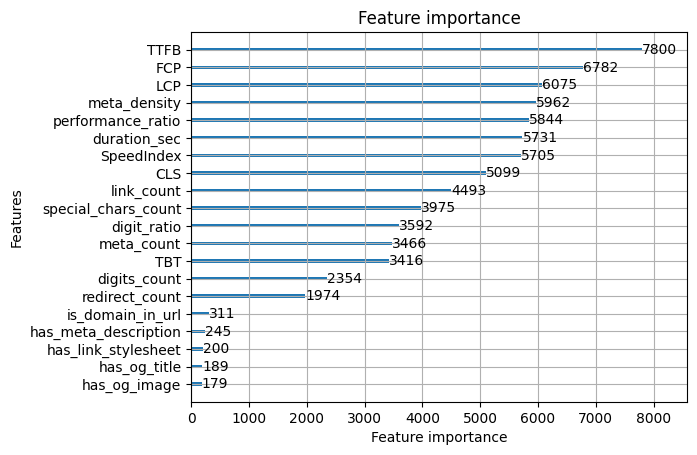

In [16]:
lgb.plot_importance(model, max_num_features=20)

C:\Users\taka2\AppData\Local\Temp\ipykernel_36444\1322111581.py:18: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\taka2\.pyenv\pyenv-win\versions\3.10.2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


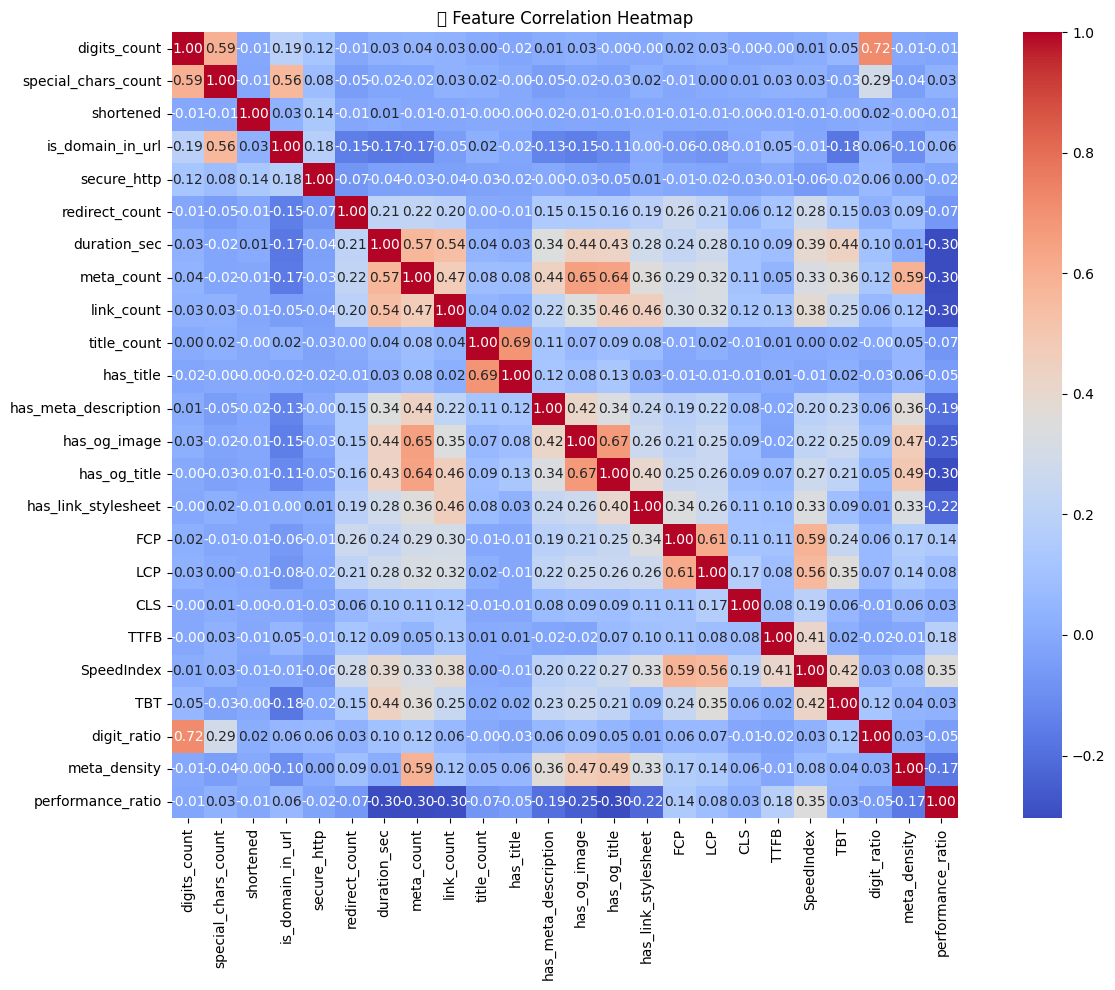

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# 숫자형 데이터만 선택
# numeric_df = df.select_dtypes(include=['number'])
numeric_df = df.select_dtypes(include=['int64', 'float64', 'bool'])
numeric_df = numeric_df.drop(columns=['url_type', 'url_len', 'letters_count','performance_score'])

# 상관관계 계산
corr = numeric_df.corr()

# 히트맵 그리기
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("📊 Feature Correlation Heatmap")
plt.tight_layout()
plt.show()
